# Twitter Sentiment Analysis

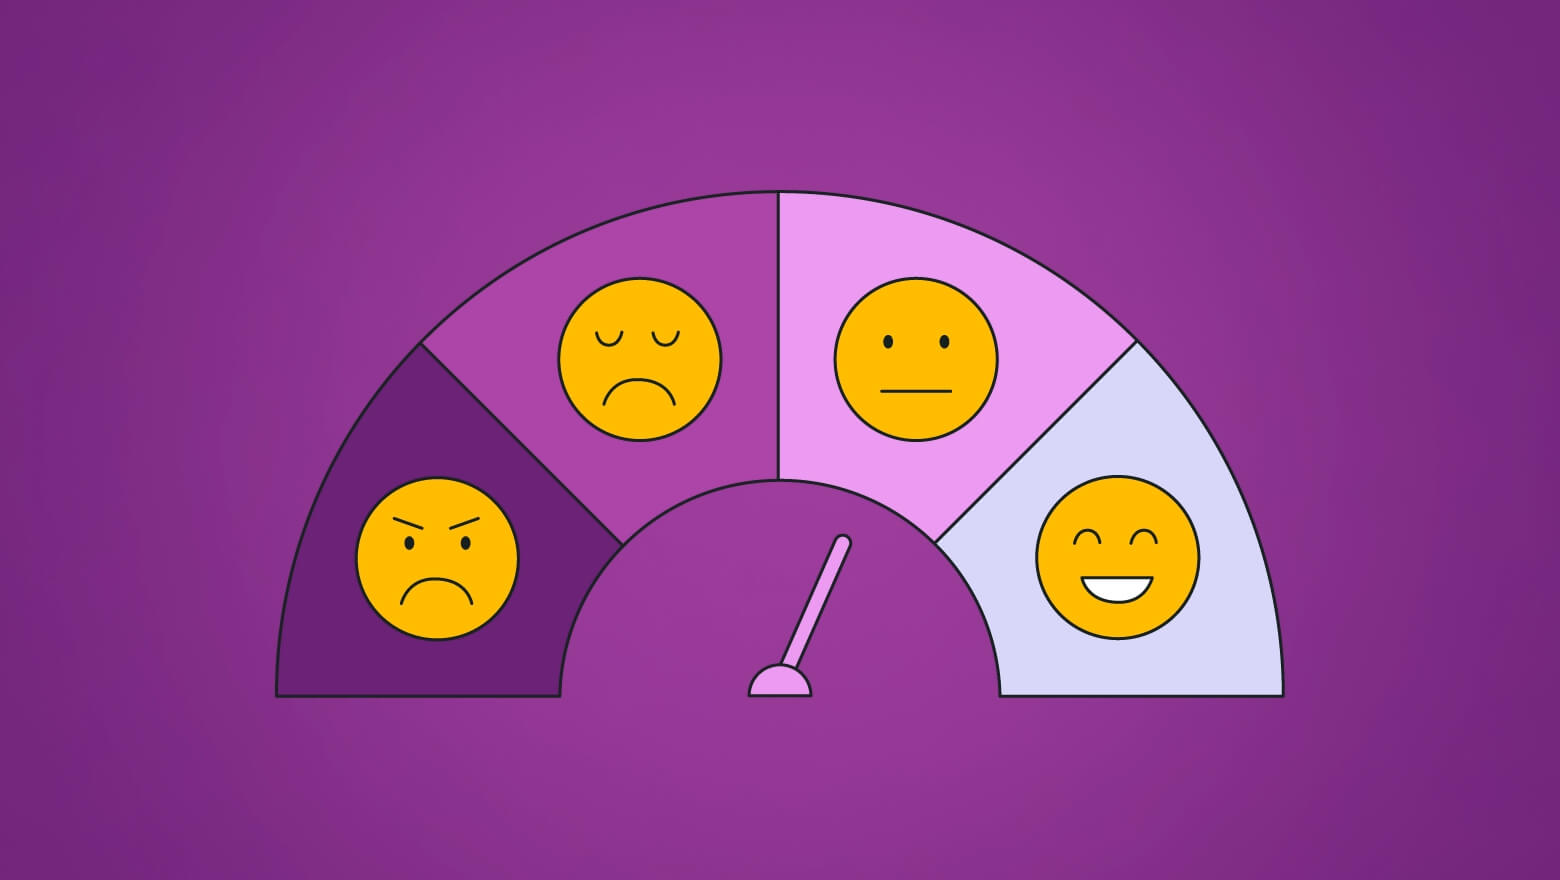

## Summary
In this project, we analyzed customer feedback on products using tweets sourced from [CrowdFlower](https://data.world/crowdflower/brands-and-product-emotions). The dataset contains over 9,000 tweets about products such as iPhones and Google products, with labeled sentiments (positive, negative, or neutral). The goal was to build a sentiment classifier to understand public opinion better. Since sentiment analysis of unstructured text is essential for businesses to maintain brand reputation, Twitter provided an excellent source of rich, user-generated content for this task.

For data preparation, we first cleaned the tweet text by removing mentions, URLs, hashtags, emojis, special characters, and extra whitespaces. We also tokenized the text, removed stopwords using NLTK, and applied lemmatization to standardize word forms. This cleaned text was then stored in a `cleaned_text` column, which was used for feature extraction. We used `TfidfVectorizer` to transform the text into numerical vectors, selecting the top 5,000 features while removing common English stopwords.

In the modeling phase, we employed multiple classifiers, including Logistic Regression, Random Forest, and Neural Networks, fine-tuning them through hyperparameter optimization. `RandomizedSearchCV` was used to identify the best hyperparameters for each model. The `TensorFlow` library was used to construct a neural network with multiple hidden layers, allowing for effective learning of complex patterns in the data.

The final model achieved an F1-score of approximately 0.6602, demonstrating solid predictive performance. We used a stratified train-test split for validation, ensuring that class distributions were maintained in both training and testing datasets. This project illustrates the potential of machine learning in deriving actionable insights from consumer sentiment expressed on social media platforms.


## Business understanding

In todays digital landscape, understanding customer feedback is a crucial step in maintaining brand reputation and enhancing customers reputation social media platforms like twitter provide an abundance of feedback where user express their opinions

### **Objectives**
The goal of this project is to analyze sentiment in tweets directed at specific brands and products. By determining whether the sentiment is positive or negative, businesses can gain valuable insights into customer satisfaction, emerging trends, and potential areas of improvement.

This project helps answer the following business questions:
* Themes or issues are associated with negative sentiment?
* Which products or brands receive the most positive or negative feedback
* How do customer percive various products and services

Achieving this goal involves the following sub-objectives:

1. **Data Collection and Preparation**: Gather relevant data and preprocess it to ensure it is suitable for analysis and modeling.
2. **Exploratory Data Analysis (EDA)**: Conduct a thorough analysis of the dataset to uncover patterns, trends, and relationships within the data, providing insights into the distribution of sentiments and identifying any potential challenges in classification.
3. **Model Development**: Implement and compare multiple machine learning models, including Logistic Regression and Neural Networks, to determine the most effective approach for sentiment classification.
4. **Performance Evaluation**: Evaluate the models' performance using appropriate metrics, focusing on precision, recall, and F1-scores, to identify the best-performing model.
5. **Actionable Insights**: Provide actionable insights and recommendations based on the analysis, helping businesses to understand consumer sentiment better and improve their strategies.



## Data Understanding

The dataset utilized for this project is sourced from [CrowdFlower](https://data.world/crowdflower/brands-and-product-emotions), specifically targeting brand and product emotions expressed in tweets. It consists of labeled text data, categorizing sentiments into positive, neutral, negative and can't tell classes.

### Dataset Overview
* **tweet_text:** The raw text of the tweet, which serves as the primary source of information for understanding user sentiment.
* **motion_in_tweet_is_directed_at:** This column specifies which product or brand the tweet is referring to (e.g., iPhone, Google).
* **is_there_an_emotion_directed_at_a_brand_or_product:** Labels the sentiment associated with the tweet (positive, neutral, negative).





## Data Exploration and Preprocessing


In this section, we will preprocess and explore the dataset to prepare it for analysis and modeling while gaining a deeper understanding of its key features.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.decomposition import PCA
import nltk
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
# df = pd.read_csv('/content/judge-1377884607_tweet_product_company.csv', encoding='latin-1')

In [3]:
df = pd.read_csv('judge-1377884607_tweet_product_company.csv', encoding='latin-1')

In [4]:
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [5]:
# renaming the columns for easier workflow
df.rename(columns={'tweet_text': 'tweet', 'emotion_in_tweet_is_directed_at': 'product', 'is_there_an_emotion_directed_at_a_brand_or_product': 'sentiment', }, inplace=True)
df.head()

,tweet,product,sentiment
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet      9092 non-null   object
 1   product    3291 non-null   object
 2   sentiment  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [7]:
# removing the row from sentiment column where a tweet is missing
df = df.dropna(subset=['tweet'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9092 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet      9092 non-null   object
 1   product    3291 non-null   object
 2   sentiment  9092 non-null   object
dtypes: object(3)
memory usage: 284.1+ KB


In [8]:
df['product'].isna().sum()

5801

In [9]:
# filling in the missing values
df['product'].fillna('Missing')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9092 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet      9092 non-null   object
 1   product    3291 non-null   object
 2   sentiment  9092 non-null   object
dtypes: object(3)
memory usage: 284.1+ KB


In [10]:
df['sentiment'].value_counts()

,count
sentiment,
No emotion toward brand or product,5388
Positive emotion,2978
Negative emotion,570
I can't tell,156


In the following step, we renamed the sentiment labels to simplify and standardize the categories. The following replacements were made:

- 'No emotion toward brand or product' → 'neutral'
- 'Positive emotion' → 'positive'
- 'Negative emotion' → 'negative'
- 'I can't tell' → 'can't tell'

After renaming, we filtered out the 'can't tell' sentiments to focus our analysis on the remaining categories (neutral, positive, and negative).

In [11]:
# renaming sentiment labels
df['sentiment'] = df['sentiment'].replace({'No emotion toward brand or product': 'neutral',
                                           'Positive emotion': 'positive',
                                           'Negative emotion': 'negative',
                                           'I can\'t tell': 'can\'t tell'})

# filtering out the can't tell sentiments
df = df[df['sentiment'] != "can't tell"]

df['sentiment'].value_counts()

,count
sentiment,
neutral,5388
positive,2978
negative,570


Next step we applied a function to clean the tweet text for analysis. The function was applied to the `tweet` column to create a new `cleaned_text` column for further analysis.

In [12]:
def clean_text(text):
    # checking if text is a string before applying regex
    if isinstance(text, str):
        # removing mentions (@username)
        text = re.sub(r'@\w+', '', text)

        # removing URLs
        text = re.sub(r'http\S+|www\S+|https\S+', '', text)

        # removing hashtags
        text = re.sub(r'#\w+', '', text)

        # removing extra whitespaces
        text = re.sub(r'\s+', ' ', text).strip()

        # removing emojis
        text = re.sub(r'[^\x00-\x7F]+', '', text)

        # removing special characters and numbers
        text = re.sub(r'[^a-zA-Z\s]', '', text)

        # removing punctuation
        text = re.sub(r'[^\w\s]', '', text)

        # converting to lowercase
        text = text.lower()
    return text

# applying cleaning to the dataset
df['cleaned_text'] = df['tweet'].apply(clean_text)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8936 entries, 0 to 9092
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   tweet         8936 non-null   object
 1   product       3282 non-null   object
 2   sentiment     8936 non-null   object
 3   cleaned_text  8936 non-null   object
dtypes: object(4)
memory usage: 349.1+ KB


In [14]:
df.head()

,tweet,product,sentiment,cleaned_text
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,negative,i have a g iphone after hrs tweeting at it ...
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,positive,know about awesome ipadiphone app that youll ...
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,positive,can not wait for also they should sale them d...
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,negative,i hope this years festival isnt as crashy as t...
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,positive,great stuff on fri marissa mayer google tim o...


Next, we initialized the stopwords and lemmatizer. A function was defined to perform tokenization, remove stopwords, and apply lemmatization to the cleaned tweet text.

The function was applied to the `cleaned_text` column, resulting in a new `processed_text` column for further analysis.


In [15]:
# initializing stopwords and lemmatizer
stop_words = set(stopwords.words('english'))
lem = WordNetLemmatizer()

# function to do tokenization, stopword removal, and lemmatization
def process_text(text):
    if isinstance(text, str):
        # tokenizing the text
        tokens = word_tokenize(text)

        # removing stopwords
        filtered_tokens = []
        for token in tokens:
          if token not in stop_words:
            filtered_tokens.append(token)

        # lemmatization
        lem_tokens = []
        for token in filtered_tokens:
          lem_tokens.append(lem.lemmatize(token))

        # joining tokens back to a single string
        return ' '.join(lem_tokens)
    return text

# applying the function to the cleaned text
df['processed_text'] = df['cleaned_text'].apply(process_text)

In [16]:
df.head()

,tweet,product,sentiment,cleaned_text,processed_text
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,negative,i have a g iphone after hrs tweeting at it ...,g iphone hr tweeting dead need upgrade plugin ...
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,positive,know about awesome ipadiphone app that youll ...,know awesome ipadiphone app youll likely appre...
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,positive,can not wait for also they should sale them d...,wait also sale
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,negative,i hope this years festival isnt as crashy as t...,hope year festival isnt crashy year iphone app
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,positive,great stuff on fri marissa mayer google tim o...,great stuff fri marissa mayer google tim oreil...


## Exploratory Data Analysis

In this section, we performed several visualizations to gain insights into the sentiment of tweets:

- **Count of Sentiments:** We visualized the distribution of sentiments in the dataset to understand overall sentiment trends.
- **Sentiment Distribution by Product:** This visualization highlighted how sentiments vary across different products, revealing brand-specific perceptions.
- **Average Tweet Length by Sentiment:** We calculated the length of each tweet and visualized the average length associated with each sentiment to identify any patterns.
- **Most Common Tokens:** This analysis showcased the most frequently used tokens in the tweets, providing insights into prevalent themes.
- **Word Cloud:** We generated a word cloud to visually represent commonly used words, emphasizing the most significant terms in the dataset.


In the following step, we applied TF-IDF vectorization to the `processed_text` column. This technique transforms the text data into numerical features, highlighting the importance of words in the context of the dataset.

We set a maximum of 5000 features and excluded common English stopwords to improve the relevance of the features. The resulting sparse matrix was then converted into a DataFrame for easier inspection of the TF-IDF features.

In [17]:
tfidf = TfidfVectorizer(max_features=5000, stop_words='english')

# Fit and transform the processed_text column
X = tfidf.fit_transform(df['processed_text'])

# converting the resulting sparse matrix to a DataFrame for easier inspection
X_tfidf = pd.DataFrame(X.toarray(), columns=tfidf.get_feature_names_out())

X_tfidf


,aapl,aaron,ab,abba,abc,ability,able,abnormal,absolutely,absolutley,...,zip,zite,zlf,zms,zombie,zomg,zone,zoom,zuckerberg,zynga
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8931,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8932,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8933,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8934,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We reduce the dimensionality of X_tfidf to 2 components to simplify visualization.

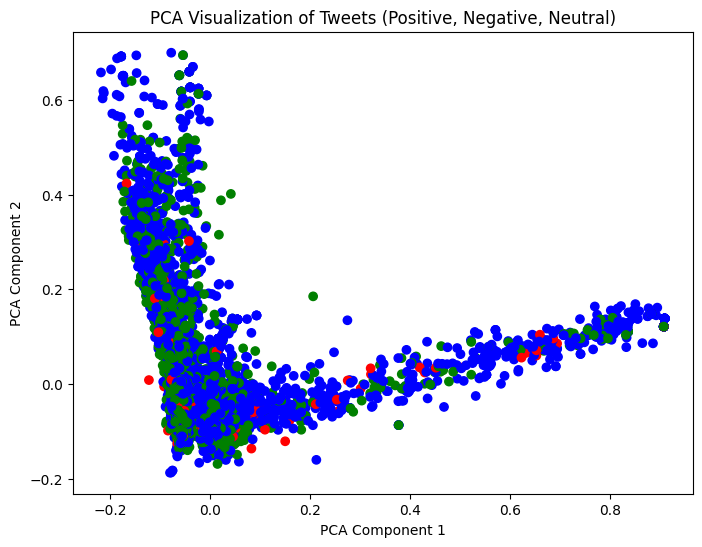

In [18]:
# applying PCA to reduce the dimensionality to 2 components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_tfidf)

# plotting the PCA result with a scatter plot
plt.figure(figsize=(8, 6))

# mapping sentiment labels to color for visualization
sentiment_colors = {
    'negative': 'red',
    'positive': 'green',
    'neutral': 'blue'
}
colors = df['sentiment'].map(sentiment_colors)

# scatter plot with PCA components
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=colors)
plt.title('PCA Visualization of Tweets (Positive, Negative, Neutral)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

**a) Visualizing the count of sentiments**

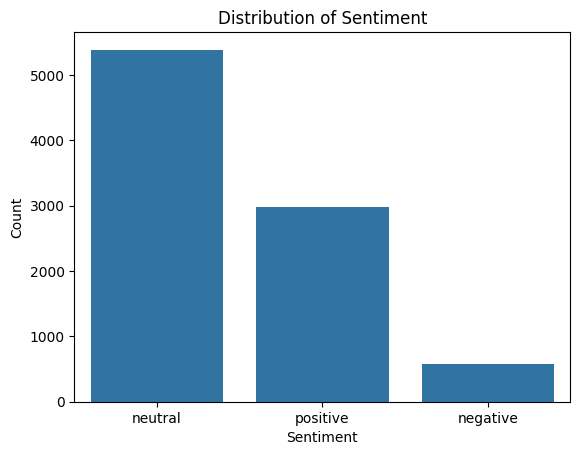

In [19]:
sentiment_counts = df['sentiment'].value_counts()
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values)
plt.title('Distribution of Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

Neutral sentiments are the highest indicating that a large portion of the tweets are mostly informational about the products being reviewed. Positive sentiments outweighs negative sentiment by a significant difference which would indicate good performance and the clients are happy about the products that they own.

**b) Visualizing how sentiments are distributed across different products**

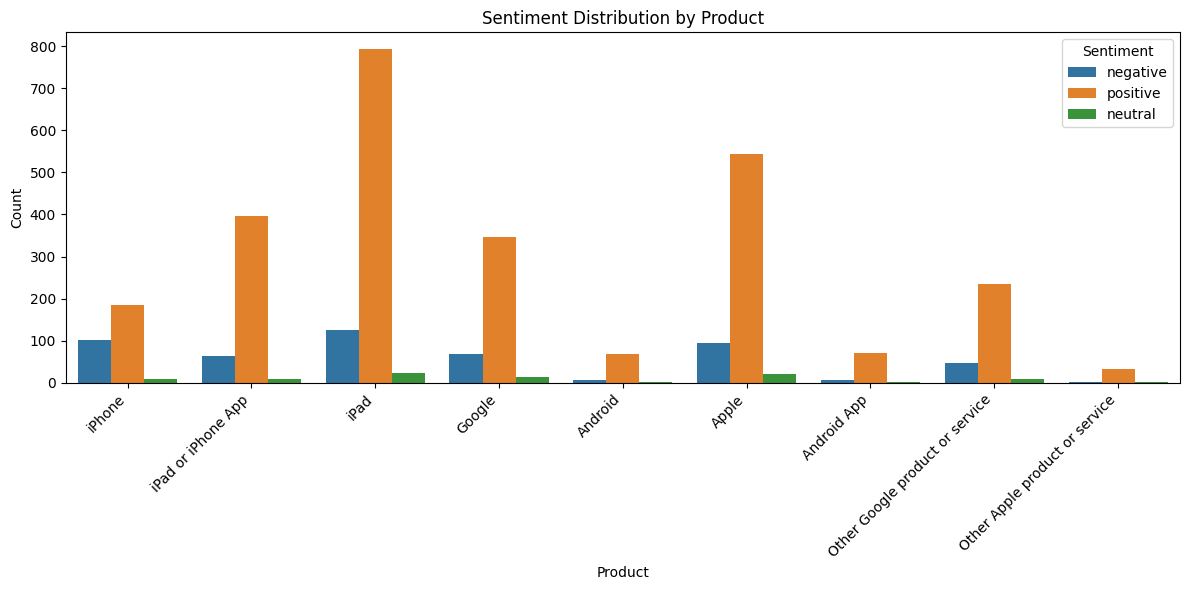

In [20]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='product', hue='sentiment')
plt.xticks(rotation=45, ha='right')
plt.title('Sentiment Distribution by Product')
plt.xlabel('Product')
plt.ylabel('Count')
plt.legend(title='Sentiment')
plt.subplots_adjust(bottom=0.2)
plt.tight_layout()
plt.show()

This visualization offers the following several insights:
1. Apple products (iPad, iPhone, Apple in general) consistently show high levels of positive sentiment, suggesting strong user satisfaction and excitement about these products.
2. The iPad stands out with the highest count of positive sentiment, which could indicate it was a major topic of interest, possibly due to a recent or anticipated release.
3. While Google also receives more positive than negative sentiment, the ratio isn't as favorable as Apple's. This could suggest a stronger brand affinity or product satisfaction among Apple users in this dataset.
4. Android has a relatively low count of mentions compared to iOS devices, but still maintains a positive skew. This might indicate less buzz around Android at this particular scenario, but still a generally positive perception.
5. Both "iPhone App" and "iPad or iPhone App" categories show strong positive sentiment, highlighting the importance of the app ecosystem in user satisfaction for these platforms.

**c) Calculating the length of each tweet and visualizing the average length by sentiment**

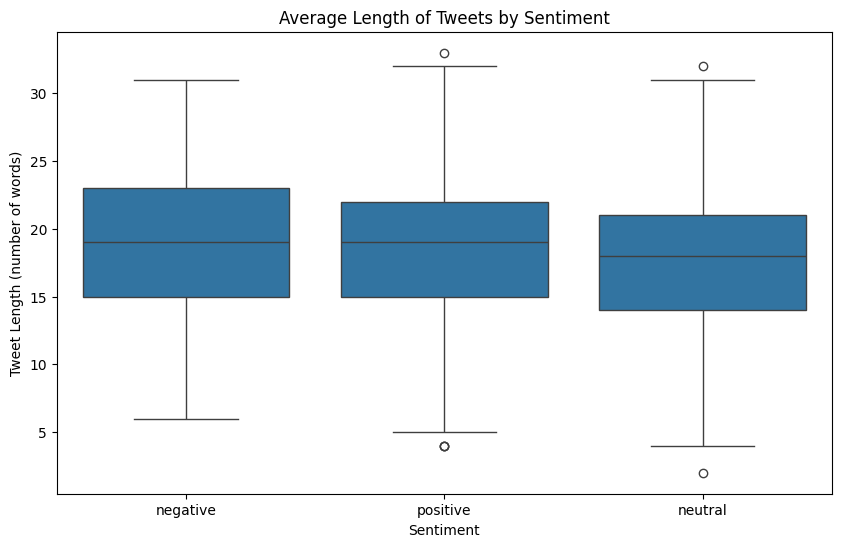

In [21]:
df['tweet_length'] = df['tweet'].apply(lambda x: len(x.split()))
plt.figure(figsize=(10, 6))
sns.boxplot(x='sentiment', y='tweet_length', data=df)
plt.title('Average Length of Tweets by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Tweet Length (number of words)')
plt.show()

The above box plot indicates that the average length of tweets is relatively similar across sentiments, with negative tweets being slightly longer on average which could indicate that users tend to provide more explanation or context when expressing criticism or dissatisfaction.

**d) Visualizing the most common tokens**

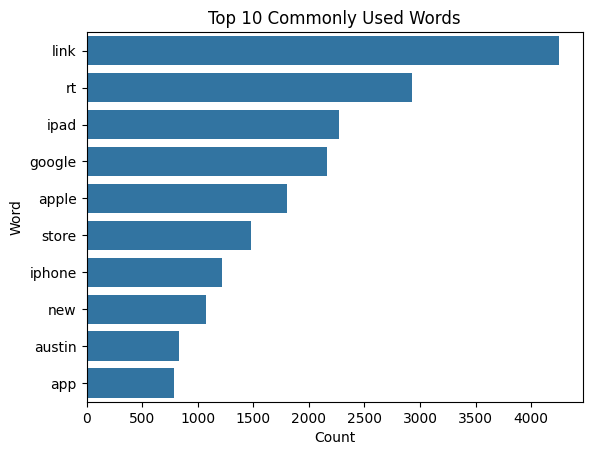

In [22]:
from collections import Counter

all_words = ' '.join(df['processed_text']).split()
word_counts = Counter(all_words)
common_words = word_counts.most_common(10)

# creating a DataFrame for better visualization
common_words_df = pd.DataFrame(common_words, columns=['Word', 'Count'])
sns.barplot(x='Count', y='Word', data=common_words_df)
plt.title('Top 10 Commonly Used Words')
plt.show()

The above bar graph shows the top 10 most commonly used words, with `link` appearing the most than others. This suggests that sharing links was a common practice during the discussions on rating Google and Apple products. The high frequency of `rt` which is presumably short for retweet indicates that content was shared and amplified widely. `iPad` and `iPhone` were the Apple products that were discudssed the most.

**e) A word cloud to visualize commonly used words**

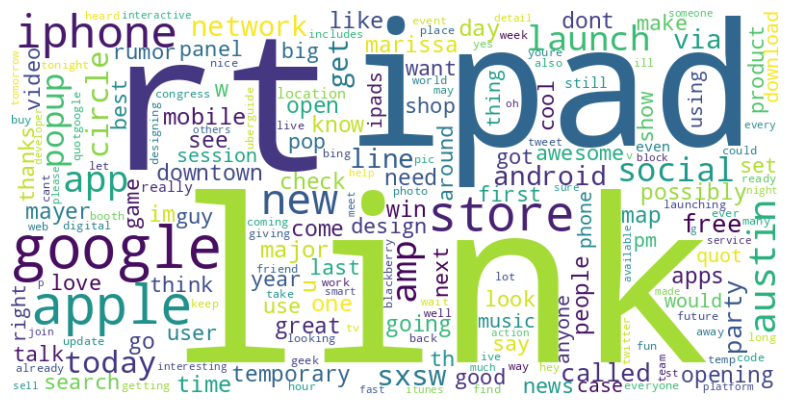

In [23]:
# combining all processed text into a single string
all_processed_text = ' '.join(df['processed_text'])

# counting word frequencies
word_freq = Counter(all_processed_text.split())

# creating the word cloud from frequencies
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

# plotting
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

While the bar graph gave us the top 10 common words, the word cloud shows us more words that were common during the opinion review of the products.
Upon further research The prominence of `Austin` and `SXSW` suggests that much of the opinions were centered around the South by Southwest (SXSW) conference, an annual event held in Austin, Texas that focuses on technology, film, and music. The large presence of terms like `app`, `Google`, `iPad`, `iPhone`, `launch`, `new` and `party`indicates that the technology aspect of the SXSW conference was the major focus with the discussion being around cutting-edge innovations on Google and Apple products.

- Overall, we see neutral sentiments are consistently present but generally lower than positive sentiment. This suggests that while there is some reporting, users are more inclined to express positive opinions about their encounters with tech products and services.

- While there are negative sentiments across products they are considerably low. This could indicate generally high satisfaction with the products reviewed, or an optimistic atmosphere of tech conferences where new and improved products are showcased.

## Modeling

In this section, we explored various models to evaluate their performance in predicting tweet sentiment:

1. Baseline Model (Logistic Regression) - we established a baseline model using Logistic Regression to provide a reference point for subsequent models.

2. Logistic Regression Tuned Model - we improved upon the baseline by tuning hyperparameters in the Logistic Regression model to enhance its performance.

3. Random Forest - next, we implemented a Random Forest model, leveraging its ability to handle complex relationships and interactions in the data.

4. Ensemble Model of Logistic Regression and Random Forest - to further improve predictive accuracy, we created an ensemble model combining the strengths of both the Logistic Regression and Random Forest models.

5. Neural Networks - finally, we explored a Neural Network model, harnessing its capacity for learning intricate patterns in the data.


We started by splitting the data into training and testing sets to avoid data leakage.

In [24]:
X = X_tfidf
y = df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# print("Training set size:", X_train.shape)
# print("Test set size:", X_test.shape)


In [25]:
y.value_counts()

,count
sentiment,
neutral,5388
positive,2978
negative,570


The data shows a significant class imbalance. The `negative` class is underrepresented compared to `neutral` and `positive` classes.

The imbalance might lead to models being biased toward predicting the majority classes (neutral and positive). This can result in poor performance, especially for the minority class (negative).
To address  the class imbalance we will apply **Class Weighting Technique**.

**Focus Metric**

Precision measures measures how many of the predicted positive cases were actually positive while recall measures how many actual positive cases were correctly identified by the model.

**F1-Score** will be our key metric because it will ensure there is a balance in both precision and recall i.e. false positives and false negatives. It will ensure good performance on all classes (positive, negative, and neutral) without one class dominating the results.

### 1. Baseline Model - Logistic Regression

Baseline Model f1 score: 0.6499800276688539



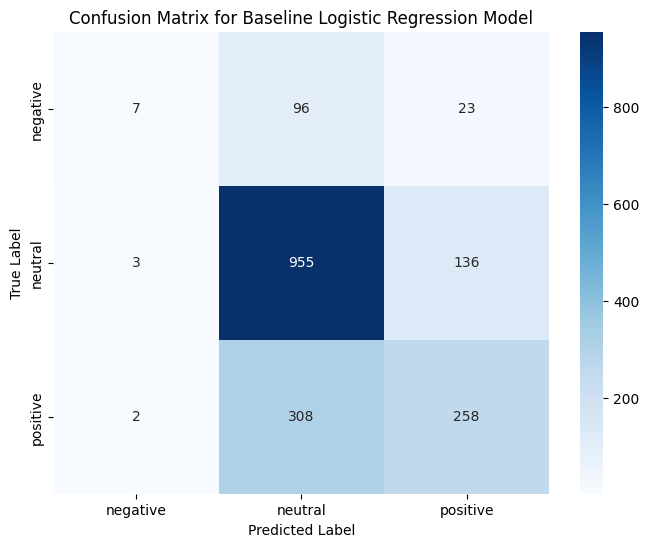

In [26]:
# Initialize the Logistic Regression model
baseline_model = LogisticRegression(random_state=42)

# Fit the model on the training data
baseline_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_baseline = baseline_model.predict(X_test)

# evaluating using F1-score
baseline_f1_score = f1_score(y_test, y_pred_baseline, average='weighted')
print("Baseline Model f1 score:", baseline_f1_score)
print()

# plotting the confusion matrix
cm = confusion_matrix(y_test, y_pred_baseline, labels=['negative', 'neutral', 'positive'])

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['negative', 'neutral', 'positive'], yticklabels=['negative', 'neutral', 'positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Baseline Logistic Regression Model')
plt.show()

#### **Model Inferences**

- The model achieved an f1-score of approximately 65%, meaning it has an average balance between precision and recall for the positive, neutral, and negative classes.

- The model performs best in predicting neutral tweets, with a high number of true neutrals (955 out of 1094), though it still misclassifies a notable number of neutrals as positive.

- Only 7 negative tweets were correctly identified, and the model tends to predict neutral more frequently, showing significant misclassification (96 negatives as neutral).
- The model also struggles with positive tweets, with a substantial number being classified as neutral (308).


### 2. Logistic Regression Tuned Model

Best Hyperparameters: {'logisticregression__solver': 'liblinear', 'logisticregression__penalty': 'l2', 'logisticregression__max_iter': 100, 'logisticregression__class_weight': 'balanced', 'logisticregression__C': 1}

Improved Model f1 score: 0.660203628588849



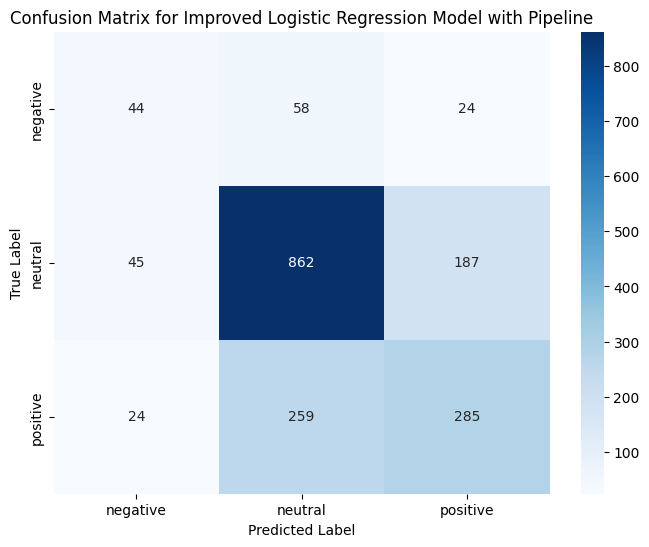

In [27]:
# Define the hyperparameter distribution, including class_weight
param_distributions = {
    'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'logisticregression__solver': ['liblinear', 'lbfgs', 'saga'],
    'logisticregression__class_weight': ['balanced', None],
    'logisticregression__penalty': ['l1', 'l2'],
    'logisticregression__max_iter': [100, 200, 300]
}

# Create a pipeline with Logistic Regression
pipeline = Pipeline([
    ('logisticregression', LogisticRegression())
])

# Initialize Randomized Search
random_search = RandomizedSearchCV(pipeline,
                                   param_distributions,
                                   scoring='f1_weighted',
                                   n_iter=10,
                                   cv=5,
                                   random_state=42,
                                   n_jobs=-1)

# Fit the model on the training data
random_search.fit(X_train, y_train)

# Get the best parameters
best_params = random_search.best_params_
print("Best Hyperparameters:", best_params)
print()

# Predict using the best model
best_model = random_search.best_estimator_
y_pred_tuned = best_model.predict(X_test)

# Evaluate the tuned model
best_f1_score = f1_score(y_test, y_pred_tuned, average='weighted')
print("Improved Model f1 score:", best_f1_score)
print()

# Confusion Matrix
cm_best = confusion_matrix(y_test, y_pred_tuned, labels=['negative', 'neutral', 'positive'])

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_best, annot=True, fmt="d", cmap="Blues",
            xticklabels=['negative', 'neutral', 'positive'],
            yticklabels=['negative', 'neutral', 'positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Improved Logistic Regression Model with Pipeline')
plt.show()

#### **Model Inferences**
- The tuned model identified the following hyperparameters:
 - Solver: liblinear
 - Penalty: l2
 - Max Iterations: 100
 - Class Weight: balanced
 - Regularization Strength (C): 1
- The use of `class_weight='balanced'` has effectively addressed class imbalance, leading to better performance across all sentiment classes, especially for the negative class.

- The improved model achieved an F1 score of approximately 66%. This is a notable improvement over the baseline F1 score of about 65%. Although the improvement is slight, it suggests that the tuning process had a positive effect on the model's ability to balance precision and recall across all classes.
-  The significant increase in correctly identifying negative tweets (from 7 to 44) indicates that the model has effectively addressed one of the major shortcomings of the baseline model.
- The model maintains a robust performance for neutral sentiments, achieving 862 correct predictions. However, the increase in misclassifications (from 3 to 45) signals that while the model is still effective, it has become more cautious, possibly at the expense of accuracy in distinguishing between neutral and negative sentiments.
-  The slight improvement in identifying positive sentiments (from 258 to 285) indicates progress in recognizing positive tweets but increase in misclassifications of positive tweets as neutral (from 308 to 259) reflects that the model still struggles with this distinction.

##### **Conclusion**

The hyperparameter tuning process has yielded a model that performs better than the baseline. The improvements in the confusion matrix highlight a better understanding of the negative sentiment, which was a major weakness in the initial model. While the performance for neutral sentiments remains strong, there's still room for improvement, particularly in distinguishing between neutral and positive classes.
Thus, we will explore **Random Forest** which is a more complex model to see if we will attain better results.



### 3. Random Forest

Best Hyperparameters: {'randomforestclassifier__n_estimators': 200, 'randomforestclassifier__min_samples_split': 10, 'randomforestclassifier__min_samples_leaf': 2, 'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__max_depth': None, 'randomforestclassifier__class_weight': 'balanced'}

Tuned Random Forest Model f1 score: 0.63754928874986



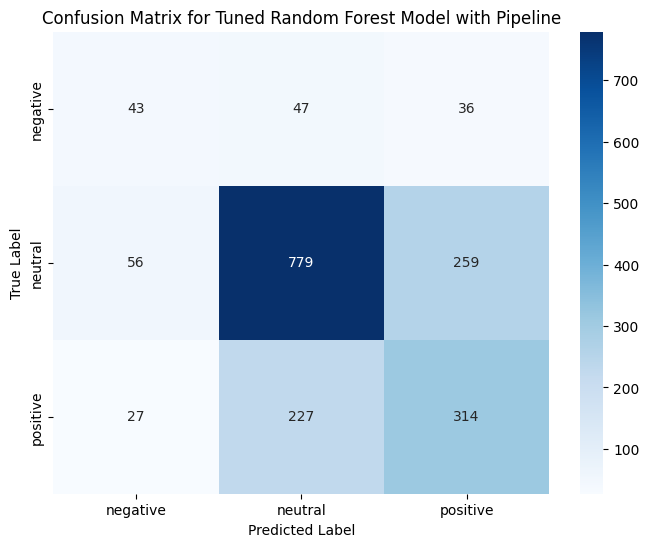

In [28]:
# Define the hyperparameter distribution for Random Forest
param_distributions_rf = {
    'randomforestclassifier__n_estimators': [10, 50, 100, 200],
    'randomforestclassifier__min_samples_split': [2, 5, 10],
    'randomforestclassifier__min_samples_leaf': [1, 2, 4],
    'randomforestclassifier__max_features': ['sqrt', 'log2'],
    'randomforestclassifier__max_depth': [None, 10, 20, 30, 40, 50],
    'randomforestclassifier__class_weight': ['balanced', None],
}

# Create a pipeline with Random Forest
pipeline_rf = Pipeline([
    ('randomforestclassifier', RandomForestClassifier(random_state=42))
])

# Initialize Randomized Search
random_search_rf = RandomizedSearchCV(pipeline_rf,
                                       param_distributions_rf,
                                       scoring='f1_weighted',
                                       n_iter=10,
                                       cv=5,
                                       random_state=42,
                                      n_jobs=-1)

# Fit the model on the training data
random_search_rf.fit(X_train, y_train)

# Get the best parameters
best_params_rf = random_search_rf.best_params_
print("Best Hyperparameters:", best_params_rf)
print()

# Predict using the best model
best_model_rf = random_search_rf.best_estimator_
y_pred_rf_tuned = best_model_rf.predict(X_test)

# Evaluate the tuned model
best_f1_score_rf = f1_score(y_test, y_pred_rf_tuned, average='weighted')
print("Tuned Random Forest Model f1 score:", best_f1_score_rf)
print()

# Confusion Matrix
cm_best_rf = confusion_matrix(y_test, y_pred_rf_tuned, labels=['negative', 'neutral', 'positive'])

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_best_rf, annot=True, fmt="d", cmap="Blues",
            xticklabels=['negative', 'neutral', 'positive'],
            yticklabels=['negative', 'neutral', 'positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Tuned Random Forest Model with Pipeline')
plt.show()

#### **Model Inferences**
The F1 score achieved was approximately 0.6375.

Negative Class:
- True Positives: 43
- Misclassifications: 47 (as neutral)

Neutral Class
- True Positives: 779
- Misclassifications: 56 (as negative)

Positive Class
- True Positives: 314
- Misclassifications: 227 (as neutral)



### Model Explainability
We’ll use SHAP to help visualize how much each feature contributes to the model predictions.


In [29]:
!pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 16.9 MB/s eta 0:00:00


100%|===================| 5363/5364 [09:32<00:00]       

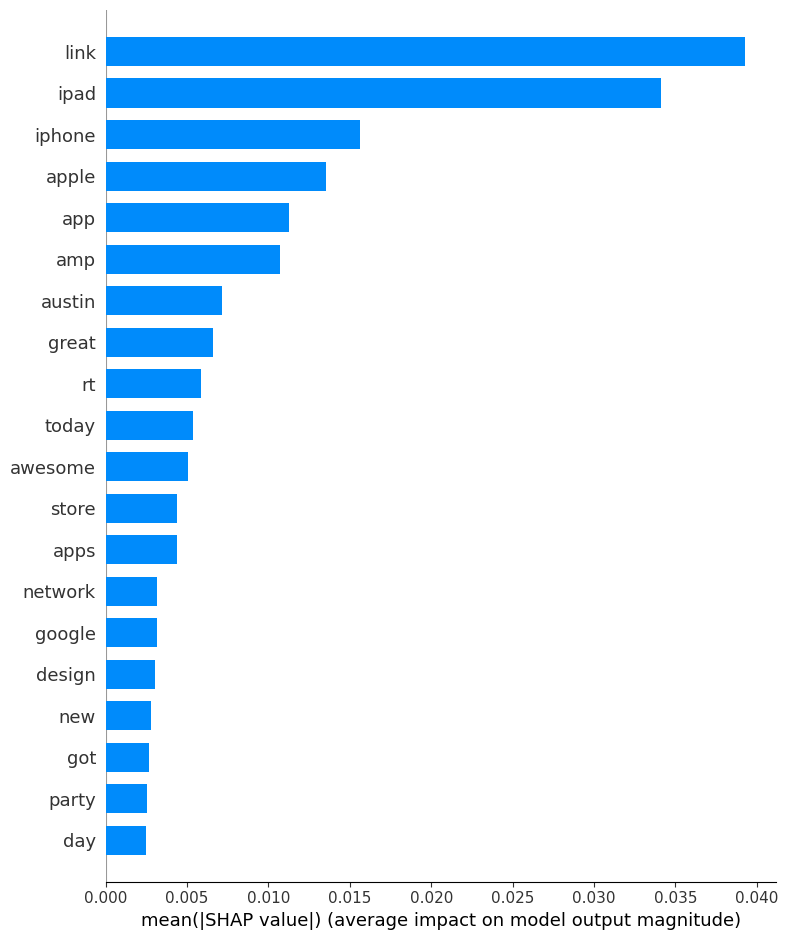

In [30]:
import shap

# Initialize and fit the Random Forest model with best hyperparameters
rf_model = RandomForestClassifier(n_estimators=200,
                                  min_samples_split=10,
                                  min_samples_leaf=2,
                                  max_features = 'sqrt',
                                  max_depth = None,
                                  random_state = 42,
                                  class_weight = 'balanced',
                                  n_jobs=-1
                                  )

rf_model.fit(X_train, y_train)

# Create a SHAP Explainer
explainer = shap.Explainer(rf_model, X_train)

# Calculate SHAP values for the test dataset
shap_values = explainer(X_test)

# Create a summary plot of SHAP values
shap.summary_plot(shap_values[:,:,1], X_test, plot_type="bar")

The chart helps interpret which features drive the model's decision. For instance, `link`, `ipad`, and `iphone` contribute significantly to the model's decision-making process in predicting sentiment. If these terms appear in a tweet, the random forest model is more likely to make a strong prediction based on their presence.

### **Tuned Logistic Regression Model vs Tuned Random Forest Model**
**a) F1-Score**

- Logistic Regression performs slightly better, achieving an F1-score of 0.6602 compared to 0.6375 for Random Forest. This means the Logistic Regression model has a better balance between precision and recall across all classes.

**b) Confusion Matrix**

- **Negatives:** Both models have a similar performance in identifying negative tweets, with 44 correct classifications for Logistic Regression and 43 for Random Forest. However, Logistic Regression misclassifies more negatives as neutral (58 vs. 47 for Random Forest).

- **Neutrals:** Logistic Regression performs significantly better in classifying neutral tweets, with 862 correct predictions, compared to 779 for Random Forest. This indicates that Logistic Regression is more effective at distinguishing neutral tweets.

- **Positives:** Random Forest outperforms Logistic Regression slightly here, with 314 correct positive classifications compared to 285. However, it still misclassifies a large number of positive tweets as neutral (227 vs. 259 for Logistic Regression).

##### **Conclusion**
- Although Random Forest performs slightly better on the positive class, Logistic Regression’s ability to better handle the neutral class is more crucial, especially if neutral tweets dominate the dataset. Misclassifying tweets as neutral instead of positive or negative can reduce the clarity of the sentiment insights we're aiming for, and Logistic Regression reduces these misclassifications thus making **Logistic Regression** better choice between the two models.

### Ensemble Model of Logistic Regression and Random Forest

Ensemble Model f1 score: 0.660799323621903



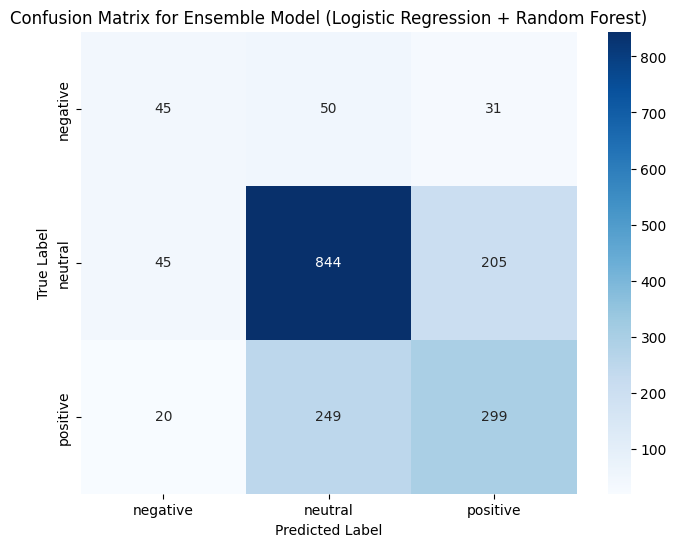

In [31]:
from sklearn.ensemble import VotingClassifier

# Tuned Logistic Regression model
log_reg = LogisticRegression(
    C=1, solver='liblinear', penalty='l2', max_iter=100, class_weight='balanced', random_state=42
)

# Tuned Random Forest model
rf_model = RandomForestClassifier(
    n_estimators=200, min_samples_split=10, min_samples_leaf=2, max_features='sqrt',
    max_depth=None, class_weight='balanced', random_state=42, n_jobs=-1
)

# Create an ensemble using VotingClassifier with soft voting
ensemble_model = VotingClassifier(
    estimators=[('log_reg', log_reg), ('rf_model', rf_model)], voting='soft'
)

# Train the ensemble model
ensemble_model.fit(X_train, y_train)

# Predict using the ensemble model
y_pred_ensemble = ensemble_model.predict(X_test)

# Evaluate using f1_score or other metrics
ensemble_f1_score = f1_score(y_test, y_pred_ensemble, average='weighted')
print("Ensemble Model f1 score:", ensemble_f1_score)
print()

# Confusion Matrix
cm_ensemble = confusion_matrix(y_test, y_pred_ensemble, labels=['negative', 'neutral', 'positive'])

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_ensemble, annot=True, fmt="d", cmap="Blues",
            xticklabels=['negative', 'neutral', 'positive'],
            yticklabels=['negative', 'neutral', 'positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Ensemble Model (Logistic Regression + Random Forest)')
plt.show()

#### **Model Inference**
The ensemble model achieved an F1 score of approximately 0.6608.


Negative Class:
- True Negatives: 45
- Misclassifications: 50 (as neutral), 31 (as positive)

Neutral Class:
- True Positives: 844
- Misclassifications: 45 (as negative), 205 (as positive)

Positive Class:
- True Positives: 299
- Misclassifications: 249 (as neutral), 20 (as negative)

### **Tuned Logistic Regression vs. Ensemble Model**
**a) F1-Score**
- The ensemble model shows a slightly better F1-score (0.6608) compared to the tuned Logistic Regression (0.6602). However, the difference is marginal and does not represent a significant improvement.

**b) Confusion Matrix Comparison**

- **Negatives:**
Both models perform similarly in the negative class, though the ensemble model improves slightly by correctly classifying one more negative tweet (45 vs. 44). However, it misclassifies more negatives as positives (31 vs. 23 in Logistic Regression).

- **Neutrals:** Logistic Regression performs better at classifying neutral tweets, with 862 correct predictions compared to 844 for the ensemble model. The ensemble model makes more misclassifications by predicting 205 neutrals as positives (vs. 136 for Logistic Regression) and 45 neutrals as negatives (vs. 3 for Logistic Regression).

- **Positives:** The ensemble model performs better in the positive class, correctly identifying 299 positive tweets compared to 285 for Logistic Regression. However, the ensemble model misclassifies more positives as negatives (20 vs. 2 for Logistic Regression).

##### **Conclusion**
- The ensemble model shows marginal improvement in overall performance with a slightly higher F1-score. It performs better in identifying positive tweets but makes more mistakes in the neutral class compared to Logistic Regression.
- Logistic Regression has a more balanced performance with fewer misclassifications in the neutral and negative classes, which are crucial for sentiment analysis, especially if the dataset has a large proportion of neutral tweets.
- Overall, while the ensemble model slightly improves on the positive class, Logistic Regression remains a better choice due to its stronger handling of the neutral sentiment, which is often the hardest class to classify correctly.

### Neural Networks

Epoch 1/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.5798 - loss: 1.0036 - val_accuracy: 0.5990 - val_loss: 0.8358
Epoch 2/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.6004 - loss: 0.8125 - val_accuracy: 0.5990 - val_loss: 0.8411
Epoch 3/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.6772 - loss: 0.6202 - val_accuracy: 0.5580 - val_loss: 0.8885
Epoch 4/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9362 - loss: 0.2049 - val_accuracy: 0.5380 - val_loss: 0.9804
Epoch 5/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9531 - loss: 0.1002 - val_accuracy: 0.2550 - val_loss: 1.4377
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Neural Network Model f1 score: 0.4526212747217658



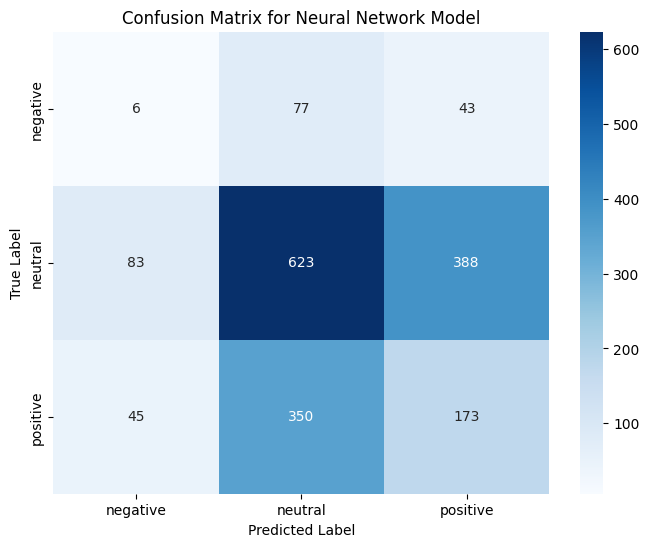

In [32]:
# Define the TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Encode the labels
encoder = LabelEncoder()
y_train_encoded = encoder.fit_transform(y_train)
y_test_encoded = encoder.transform(y_test)

# Define the Neural Network model
model = Sequential()

# Input layer and first hidden layer
model.add(Dense(128, input_shape=(X_train_tfidf.shape[1],), activation='relu'))
model.add(Dropout(0.2))

# Second hidden layer
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))

# Third hidden layer
model.add(Dense(32, activation='relu'))

# Output layer (3 classes: positive, neutral, negative)
model.add(Dense(3, activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_tfidf.toarray(), y_train_encoded, epochs=5, batch_size=64, validation_split=0.2, verbose=1)

# Evaluate the model on test data
y_pred_probs = model.predict(X_test_tfidf.toarray())
y_pred = np.argmax(y_pred_probs, axis=1)

# F1-score
nn_f1_score = f1_score(y_test_encoded, y_pred[:len(y_test_encoded)], average='weighted')
print("Neural Network Model f1 score:", nn_f1_score)
print()

# Confusion Matrix
cm_nn = confusion_matrix(y_test_encoded, y_pred[:len(y_test_encoded)])

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_nn, annot=True, fmt="d", cmap="Blues",
            xticklabels=encoder.classes_,
            yticklabels=encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Neural Network Model')
plt.show()

In [33]:
print(cm_nn)

[[  6  77  43]
 [ 83 623 388]
 [ 45 350 173]]


### **Comparison of Logistic Regression vs. Neural Networks**

**a) F1-Score**
- The Neural Network model achieved an F1-score of **0.4612**, which is significantly lower than the tuned Logistic Regression model's F1-score of **0.6602**. This indicates that the Neural Network struggles to maintain a good balance between precision and recall across all classes.

**b) Confusion Matrix Comparison**

- **Negatives:** The Neural Network failed to correctly classify any negative tweets, resulting in **3 true negatives**. All negative tweets were misclassified as either neutral (80) or positive (43), demonstrating a critical flaw in the model’s performance on this class.
  
- **Neutrals:** The Neural Network classified **631 neutral tweets correctly**, but also misclassified **408** as positive and **55** as negative. This reflects a higher level of misclassification compared to Logistic Regression, which handled the neutral class much better.
  
- **Positives:** The Neural Network identified **180 positive tweets** correctly but misclassified **356** as neutral. Again, this indicates challenges in distinguishing between positive and neutral sentiments, leading to a higher number of misclassifications compared to Logistic Regression.

##### **Conclusion**
- The Neural Network model's performance is notably poorer than that of the Logistic Regression model, with a significantly lower F1-score indicating its inability to balance precision and recall effectively across the classes.
- The Neural Network's identification of only 3 negative tweets represents a critical shortcoming, as accurately classifying negative sentiments is essential for sentiment analysis tasks.
- In contrast, Logistic Regression demonstrated a more balanced and reliable performance, particularly in classifying neutral and negative sentiments, which are often the most challenging classes.
- Overall, given its significantly better F1-score and confusion matrix performance, Logistic Regression is the superior choice for this sentiment analysis task, as it provides more accurate insights into tweet sentiments.

## Challenges Encountered
1. **Data Imbalance:** The dataset had imbalanced classes, which skewed the model’s performance.
2. **Model Performance Variability:** Different models performed variably across classes, making it a bit difficult to find one model that excelled in all aspects.
3. **Resource Intensive:** Training deep learning models was resource-intensive and time-consuming, requiring significant computational power.

## Conclusion
The project successfully analyzed Twitter sentiment toward products using various machine learning models. Logistic regression outperformed other models, including neural networks, in terms of accuracy and interpretability. This suggests that for sentiment analysis tasks, simpler models can often provide robust results without the complexity of more advanced algorithms. However, challenges such as data imbalance and feature selection highlighted the need for careful consideration when building and evaluating models.

## Recommendations
1. **Feature Engineering:** Explore additional feature engineering methods to enhance the dataset.
3. **Ensemble Methods:** Consider using ther ensemble techniques, such as bagging or boosting, to improve model performance.
4. **Hyperparameter Tuning:** Perform more extensive hyperparameter tuning using techniques like Grid Search or Bayesian Optimization to optimize model performance further.
5. **Model Interpretation:** Invest time in other model interpretation tools like LIME to better understand how features influence predictions.